# DATA DOWNLOAD
To start this project, you need an addition data file.

First you should download data from:
https://pan.baidu.com/s/1KFui9zZKjRqzFkCJH5nenw
    
Then unzip it,create a data dir, and put it in data directory

## After you do all that , the following file should be found:

```python
'data/segmented_train_seg_by_word.txt' 
```

And that means you are good to go.

In [41]:
! wc -l data/segmented_train_seg_by_word.txt

20000000 data/segmented_train_seg_by_word.txt


# DATA PROCESS

In [42]:
from utils import ProgressBar
import numpy as np
import collections
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
%matplotlib inline

# 处理中文英文原始文本，分词

In [43]:
enline = None
chline = None

sentlength = 4

enlines = []
chlines = []
pb = ProgressBar(worksum=10000000)
pb.startjob()
num = 0
with open('data/segmented_train_seg_by_word.txt',encoding='utf-8') as fhdl:
    for line in fhdl:
        num += 1
        if num % 2 == 1:
            enline = line
            continue
        else:
            chline = line
        
        enlinesp = [i.lower() for i in enline.strip("\n").split()]
        chlinesp = [i for i in chline.strip("\n").split()]
        if len(enlinesp) <= sentlength and len(chlinesp) <= sentlength:
            enlines.append(enlinesp)
            chlines.append(chlinesp)
        if (num // 2) % 1000 == 0:
            pb.complete(1000)
            
        #if num // 2 >= 1000000:
        #    break
        

 100.00 % [==================================================>] 10000000/10000000 	 used:54s eta:0 s

## 中文，英文句子分别都有150904个

In [44]:
len(enlines),len(chlines)

(150904, 150904)

## 看一些中文，英文句子的sample

In [45]:
chlines[:10]

[['一对二', '胜', '。'],
 ['一对', '五百', '诶', '。'],
 ['一对', '双胞胎', '。'],
 ['一对', '双胞胎', '女孩', '。'],
 ['一对', '同卵', '双胞胎', '。'],
 ['一对', '后进生', '。'],
 ['一对', '夫妇', '。'],
 ['一对', '夫妻', '。'],
 ['一对', '好人', '。'],
 ['一对', '少年', '男女', '。']]

In [46]:
enlines[:10]

[['deuces', 'the', 'winner', '.'],
 ['one', 'against', '500', '.'],
 ['a', 'twin', '.'],
 ['twin', 'girls', '.'],
 ['identical', 'twins', '.'],
 ['pair', 'of', 'underachievers', '.'],
 ['husband', 'and', 'wife', '.'],
 ['couple', '.'],
 ['nice', 'couple', '.'],
 ['a', 'young', 'couple', '.']]

## 思考：如何从10万多个的句子中去构建一个词表？
（词表的作用是把句子中的单词应设为一个id）

答案：需要把这些句子中单词出现频次最频繁的一些（比如top1000）抽出来来构建词表，如果使用全部单词则会导致词表太大，反而影响模型效率和效果。

In [7]:
# 把中文，英文句子中的每一个单词全部放进words这个数组中

words = []

for sent in chlines:
    for word in sent:
        words.append(word)
        
for sent in enlines:
    for word in sent:
        words.append(word)

In [47]:
# 这样以来我们有1054694 个单词组成的这个list
len(words)

1054694

In [48]:
len(set(words))

76829

In [49]:
from collections import Counter

In [50]:
# 我们可以很轻松的找出这个100W左右的单词list中出现最频繁的几个单词
Counter(words).most_common(15)

[('.', 69213),
 ('。', 64997),
 ('？', 18494),
 ('?', 18486),
 ('的', 15156),
 ('...', 15073),
 (',', 13814),
 ('，', 12598),
 ('the', 11865),
 ('我', 11374),
 ('！', 11165),
 ('!', 10976),
 ('i', 8885),
 ('你', 7707),
 ('了', 7633)]

In [51]:
def addchar(what2ind,ind2what,char):
    if char in what2ind:
        return 
    ind2what[len(what2ind)] = char
    what2ind[char] = len(what2ind)

## 构建词表

### 引入特殊符号

<pad>和<unk>分别代表着什么？

<pad>代表空白符，用于填充一个batch中不同长度句子，使其在进行填充后长度相同

<unk>代表未知单词，即在词表中没有出现过的单词，这部分单词是没有办法做word - id映射的，我们统一影射为<unk>特殊符号。

### 想一想：除了使用<unk>特殊符号来处理超出词表范围的单词，还有什么其他办法？

In [52]:
word2ind = {}
ind2word = {}

specialchars = ['<pad>','<unk>']

for one in specialchars:
    addchar(word2ind,ind2word,one)

## 利用最常用的10000个单词构建词表

In [53]:
for word,_ in Counter(words).most_common(10000):
    addchar(word2ind,ind2word,word)

In [54]:
chlines[:10]

[['一对二', '胜', '。'],
 ['一对', '五百', '诶', '。'],
 ['一对', '双胞胎', '。'],
 ['一对', '双胞胎', '女孩', '。'],
 ['一对', '同卵', '双胞胎', '。'],
 ['一对', '后进生', '。'],
 ['一对', '夫妇', '。'],
 ['一对', '夫妻', '。'],
 ['一对', '好人', '。'],
 ['一对', '少年', '男女', '。']]

## 构建训练数据集

In [60]:
dat_x_in = []
dat_y = []

for chsent,ensent in zip(chlines,enlines):
    indsent = [word2ind.get(i,word2ind['<unk>']) for i in chsent]
    dat_x_in.append(indsent)
    dat_y.append(0)
    
    indsent = [word2ind.get(i,word2ind['<unk>']) for i in ensent]
    dat_x_in.append(indsent)
    dat_y.append(1)

In [61]:
dat_x_in[:10]

[[1, 1, 3],
 [1, 10, 5685, 2],
 [2188, 1, 1, 3],
 [62, 1053, 4818, 2],
 [2188, 3712, 3],
 [17, 4273, 2],
 [2188, 3712, 589, 3],
 [4273, 761, 2],
 [2188, 1, 3712, 3],
 [8988, 3941, 2]]

In [17]:
dat_y[:10]

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

In [63]:
len(dat_x_in),len(dat_y)

(301808, 301808)

## 使用<pad>特殊符号做batch 对齐

In [64]:
dat_x_in = tf.keras.preprocessing.sequence.pad_sequences(dat_x_in,padding='post',value=word2ind['<pad>'])

In [65]:
dat_y = np.asarray(dat_y)

In [66]:
dat_x_in.shape,dat_y.shape

((301808, 4), (301808,))

In [69]:
ind2word[0]

'<pad>'

In [67]:
dat_x_in[:10]

array([[   1,    1,    3,    0],
       [   1,   10, 5685,    2],
       [2188,    1,    1,    3],
       [  62, 1053, 4818,    2],
       [2188, 3712,    3,    0],
       [  17, 4273,    2,    0],
       [2188, 3712,  589,    3],
       [4273,  761,    2,    0],
       [2188,    1, 3712,    3],
       [8988, 3941,    2,    0]], dtype=int32)

## 写数据生成器，用于产生每个batch的training的x和y数据

In [70]:
def data_generator(batch_size):
    while True:
        for i in range(0,len(dat_x_in),batch_size):
            if i + batch_size < len(dat_x_in):
                yield dat_x_in[i:i + batch_size],dat_y[i:i + batch_size]

In [71]:
gen = data_generator(256)

In [72]:
batch_x,batch_y = gen.__next__()

In [73]:
batch_x.shape ,batch_y.shape

((256, 4), (256,))

# MODEL PART

In [74]:
batch_size = 256
embedding_size = 100
vocabulary_size = len(ind2word)
num_units = 50 # hidden units

In [75]:
vocabulary_size

10002

In [76]:
import tensorflow as tf
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


In [77]:
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

with tf.device('/gpu:1'):
    initializer = tf.random_uniform_initializer(
        -0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
    
    # 注意观察这几个输入的形状
    # 问题：这些输入分别对应了ppt上网络的哪个部分？
    x = tf.placeholder("int32", [None, None]) # (256,4)
    y = tf.placeholder("int32", [None]) # (256)
    x_len = tf.placeholder("int32",[None]) # (256,) => (4,4,4,4...)
    
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    # embedding
    embedding_encoder = tf.get_variable(
        "embedding_encoder", [vocabulary_size, embedding_size],dtype=tf.float32)
    encoder_emb_inp = tf.nn.embedding_lookup(
        embedding_encoder, x)
    # 256 x 4 x 100
    
    # Build RNN cell
    encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
    
    # Run Dynamic RNN
    #   encoder_outputs: [max_time, batch_size, num_units]
    #   encoder_state: [batch_size, num_units]
    # tf.nn.static_rnn
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_emb_inp,
        sequence_length=x_len, time_major=False,dtype=tf.float32)
    
    model_logistic = tf.layers.dense(encoder_state[0],1)
    model_pred = tf.nn.sigmoid(model_logistic)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(y,tf.float32),logits=tf.reshape(model_logistic,(-1,)))
    loss = tf.reduce_mean(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    

In [78]:
session.run(tf.global_variables_initializer())

In [79]:
losses = []
beginning_lr = 0.1
gen = data_generator(batch_size)
for one_epoch in range(0,1):
    pb = ProgressBar(worksum=len(dat_x_in))
    pb.startjob()
    for one_batch in range(0,len(dat_x_in),batch_size):
        batch_x,batch_y = gen.__next__()
        batch_x_len = np.asarray([len(i) for i in batch_x])
        batch_lr = beginning_lr 
        
        _,batch_loss = session.run([optimizer,loss],feed_dict={
            x:batch_x,
            y:batch_y,
            x_len:batch_x_len,
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch,one_batch,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)

EPOCH 0 batch 301568 lr 0.1 loss 0.1614968478679657 100.01 % [==================================================>] 301824/301808 	 used:7s eta:0 s

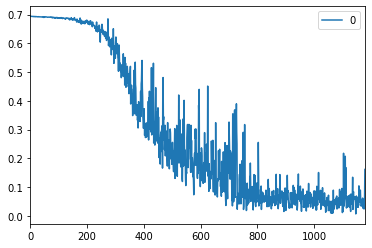

In [80]:
%matplotlib inline
pd.DataFrame(losses).plot()

# run predict

In [81]:
def predict_result(sent):
    senttoken = [word2ind.get(i.lower(),word2ind["<unk>"]) for i in sent.split()]
    inputx = np.asarray([senttoken])
    inputx_len = np.asarray([len(senttoken)])
    
    print(inputx,inputx_len)
    batch_predict = session.run(model_pred,feed_dict={
            x:inputx,
            x_len:inputx_len,
        })[0]
    return "英文" if batch_predict > 0.5 else "中文"

In [84]:
source_sentence = "你 好"

In [85]:
predict_result(source_sentence)

[[15 57]] [2]


'中文'